# Project Assignment A

## The idea
* Location: Afghanistan
* Aquired from: https://archive.org/details/WikileaksWarDiaryCsv (original link is dead: https://wikileaks.org/wiki/Afghan_War_Diary,_2004-2010)
* Time Span: 2004-2009
* Idea: Get an impression of who has been killed and wounded during the war and what were the main causes.
* Dataset: The secret dataset was leaked by the platform WikiLeaks in 2010 and contains every reported incident during the Afghanistan war: http://www.theguardian.com/world/2010/jul/25/afghanistan-war-logs-military-leaks. We also use GeoJSON data of Afghanistan for each district. The districts are splited in command centers for the NATO forces.

* Why: The visualization of the war reveals the devastating loses of all included parties. During the war the visualization could have been used to identify common spots for enemy forces to attack or place traps.

## Loading and Cleaning the Data

Load WikiLeaks Afghan War Diary from 2004-2009.

In [1]:
# Pandas contains useful functions for data structures with "relational" or "labeled" data
import pandas

# header as suggested
# by WikiLeaks: https://wikileaks.org/afg/
# by the Guardian: http://www.theguardian.com/world/datablog/2010/jul/25/wikileaks-afghanistan-data
header = [
    'ReportKey', # find messages and also to reference them
    'DateOccurred', 'EventType', 
    'Category', # describes what kind of event the message is about
    'TrackingNumber', 'Title', # internal tracking number and title
    'Summary', # actual description of the event
    'Region', # broader region of the event, RC = regional command
    'AttackOn', # who was attacked during an event
    'ComplexAttack', #  signifies that an attack was a larger operation that required more planning, coordination and preparatio
    'ReportingUnit', 'UnitName', 'TypeOfUnit', # information on the military unit that authored the report
    'FriendlyWounded', 'FriendlyKilled', 'HostNationWounded', 'HostNationKilled', 'CivilianWounded', 'CivilianKilled', 
    'EnemyWounded', 'EnemyKilled', 'EnemyDetained', # who was killed/wounded/captured
    'MilitaryGridReferenceSystem', 'Latitude', 'Longitude', # location
    'OriginatorGroup', 'UpdatedByGroup', # message originated from or was updated by
    'CommandersCriticalInformationRequirements', 
    'Significant', # are analyzed and evaluated by special group in command centre
    'Affiliation', # event was of friendly, neutral or enemy nature
    'DisplayColor', # enemy activity - RED, friendly activity - BLUE, afghan/neutral activity (accidents, drugs etc.) - GREEN
    'ClassificationLevel' # classification level of the message, e.g.: Secret
]

data = pandas.read_csv('./afg.csv', header=None, names=header)
# lower case some columns see problems: https://wardiaries.wikileaks.org/search/?sort=date
data['Category'] = data['Category'].str.lower()
data['Title'] = data['Title'].str.lower()
data.head()

,ReportKey,DateOccurred,EventType,Category,TrackingNumber,Title,Summary,Region,AttackOn,ComplexAttack,...,MilitaryGridReferenceSystem,Latitude,Longitude,OriginatorGroup,UpdatedByGroup,CommandersCriticalInformationRequirements,Significant,Affiliation,DisplayColor,ClassificationLevel
0,D92871CA-D217-4124-B8FB-89B9A2CFFCB4,2004-01-01 00:00:00,Enemy Action,direct fire,2007-033-004042-0756,direct fire other,KAF-1BDE -S3 REPORTS: SUMMIT 09 B CO ELEMENT S...,RC EAST,ENEMY,False,...,42SWB3900916257,32.683319,69.416107,UNKNOWN,UNKNOWN,NaN,NaN,ENEMY,RED,SECRET
1,C592135C-1BFF-4AEC-B469-0A495FDA78D9,2004-01-01 00:00:00,Friendly Action,cache found/cleared,2007-033-004738-0185,cache found/cleared other,USSF FINDS CACHE IN VILLAGE OF WALU TANGAY: US...,RC EAST,FRIEND,False,...,42SXD7520076792,35.018608,70.920273,UNKNOWN,UNKNOWN,NaN,NaN,FRIEND,BLUE,SECRET
2,D50F59F0-6F32-4E63-BC02-DB2B8422DE6E,2004-01-01 00:00:00,Non-Combat Event,propaganda,2007-033-010818-0798,propaganda other,(M) NIGHT LETTERS DISTRIBUTED AROUND HAZARJUFT...,RC SOUTH,NEUTRAL,False,...,41RPQ1439743120,31.116390,64.199707,UNKNOWN,UNKNOWN,NaN,NaN,NEUTRAL,GREEN,SECRET
3,E3F22EFB-F0CA-4821-9322-CC2250C05C8A,2004-01-01 00:00:00,Enemy Action,direct fire,2007-033-004042-0850,direct fire other,KAF-1BDE -S3: SUMMIT 6 REPORTS TIC SALUTE TO F...,RC EAST,ENEMY,False,...,42SWB3399911991,32.645000,69.362511,UNKNOWN,UNKNOWN,NaN,NaN,ENEMY,RED,SECRET
4,4D0E1E60-9535-4D58-A374-74367F058788,2004-01-01 00:00:00,Friendly Action,cache found/cleared,2007-033-004738-0279,cache found/cleared other,KAF-1BDE -S3 REPORTS: GERONIMO 11 SALUTE AS FO...,RC EAST,FRIEND,False,...,42SWB7580277789,33.236389,69.813606,UNKNOWN,UNKNOWN,NaN,NaN,FRIEND,BLUE,SECRET


Extract a glossary of military terms from the Guardian: http://www.theguardian.com/world/datablog/2010/jul/25/wikileaks-afghanistan-war-logs-glossary

In [2]:
# generate the glossary
import bs4, lxml, re, requests

link = 'http://www.theguardian.com/world/datablog/2010/jul/25/wikileaks-afghanistan-war-logs-glossary'
response = requests.get(link)
try:
    if not response.ok:
        print 'HTTP error {} trying to fetch Guradian glossary: {}'.format(response.status_code, link)
    else:
        glossary = dict()
        soup = bs4.BeautifulSoup(response.content, 'lxml')
        glossary_table = soup.find('table')
        for row in glossary_table.find_all('tr'):
                cells = row.find_all("td")
                if len(cells) == 2:
                    if cells[0].string:
                        key = str(cells[0].string.strip().lower())
                        content = cells[1].text
                        glossary[key] = content
except requests.exceptions.ConnectionError as e:
    'Connection error {} on {}'.format(e, link)

print glossary['afg']

 Afghans 


## Exploratory analysis
Some common information about the dataset

In [3]:
data['DateOccurred'] = pandas.to_datetime(data['DateOccurred'])
data['Year'] = [date.year for date in data['DateOccurred']]
data['Hour'] = [date.hour for date in data['DateOccurred']]

#Number of rows/columns
print "Number of rows: %d" % data.shape[0]
print "Number of columns: %d" % data.shape[1]

date_range = set()
for date in data['DateOccurred']:
    date_range.add(date.year)

print "\nYears:\n"
print list(date_range)

#Ocurrences of categories
print "\nNumber of unique categories: %d" %len(set(data['Category']))

#Distribution of categoriesn_occurrences[0:20]
n_occurrences = data['Category'].value_counts()

print "\nMost commonly occurring categories of crime:\n"
print n_occurrences.head()

print "\nMost commonly occurring category of crime is %s with %d" % (n_occurrences.argmax(), n_occurrences.max())
print "\nLeast commonly occurring category of crime is %s with %d" % (n_occurrences.argmin(), n_occurrences.min())

Number of rows: 76911
Number of columns: 34

Years:

[2004, 2005, 2006, 2007, 2008, 2009]

Number of unique categories: 153

Most commonly occurring categories of crime:

direct fire          16293
ied found/cleared     8581
indirect fire         7237
ied explosion         7202
other                 4693
Name: Category, dtype: int64

Most commonly occurring category of crime is direct fire with 16293

Least commonly occurring category of crime is graffiti with 1


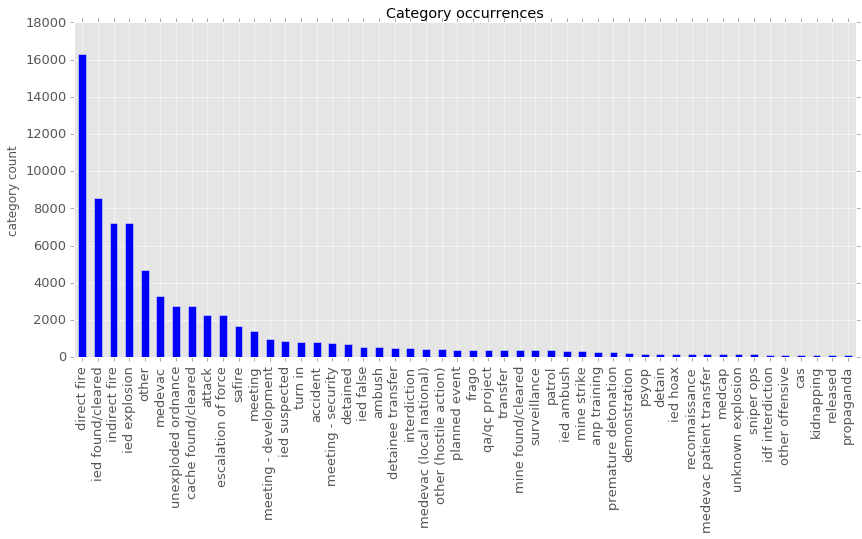

In [4]:
# plot distribution of categories (TOP 50)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

n_occurrences_top = n_occurrences[0:50]

#plot histogram
def barplot(series, title, figsize, ylabel, flag, rotation):
    #plot hist
    ax = series.plot(kind='bar', 
                title = title,
                figsize = figsize,
                fontsize = 13)
    
    # set ylabel
    ax.set_ylabel(ylabel)
    # set xlabel (depending on the flag that comes as a function parameter)
    ax.get_xaxis().set_visible(flag)
    # set series index as xlabels and rotate them
    ax.set_xticklabels(series.index, rotation= rotation)
    
barplot(n_occurrences_top,'Category occurrences', figsize=(14,6), ylabel = 'category count',flag = True, rotation = 90)

In [5]:
focus_categories = n_occurrences.index[0:8]
print focus_categories

Index([u'direct fire', u'ied found/cleared', u'indirect fire',
       u'ied explosion', u'other', u'medevac', u'unexploded ordnance',
       u'cache found/cleared'],
      dtype='object')


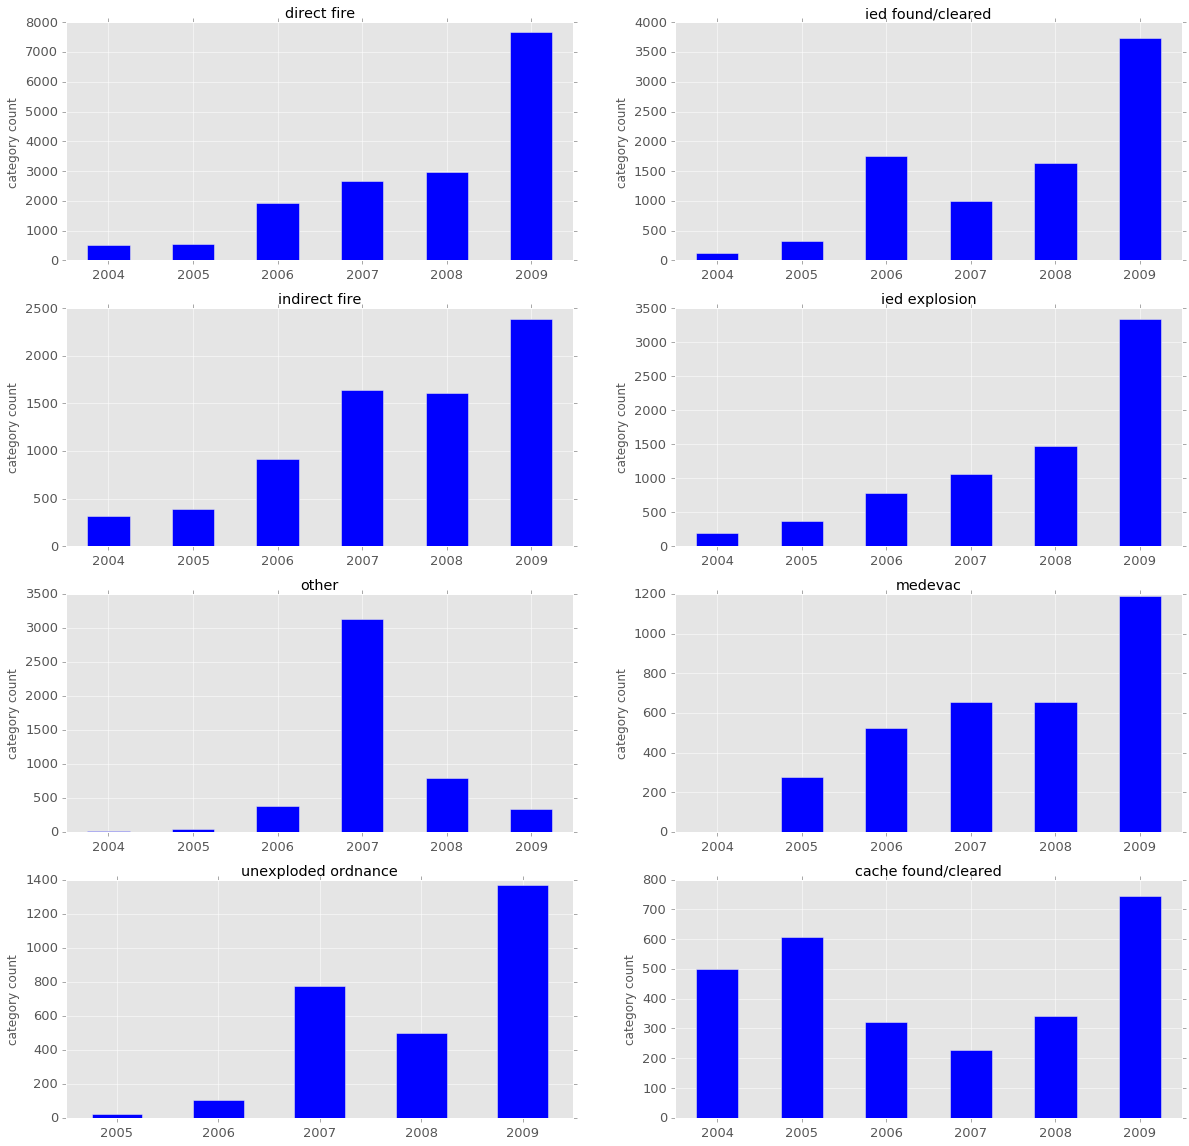

In [6]:
def yearly_category_distribution(data, focus_categories):
    
    index = 1
    for category in focus_categories:
        #filter table by type of category
        db = data[data['Category'] == category]
        #get year counts of that crime
        year_counts = db['Year'].value_counts()
        #sort it (from 2004 to 2009)
        year_counts = year_counts.sort_index()
        #plot it
        plt.subplot(7,2,index)
        barplot(year_counts, category, figsize=(20,35), ylabel = 'category count', flag = True, rotation = 0)
        index += 1
        
yearly_category_distribution(data, focus_categories)

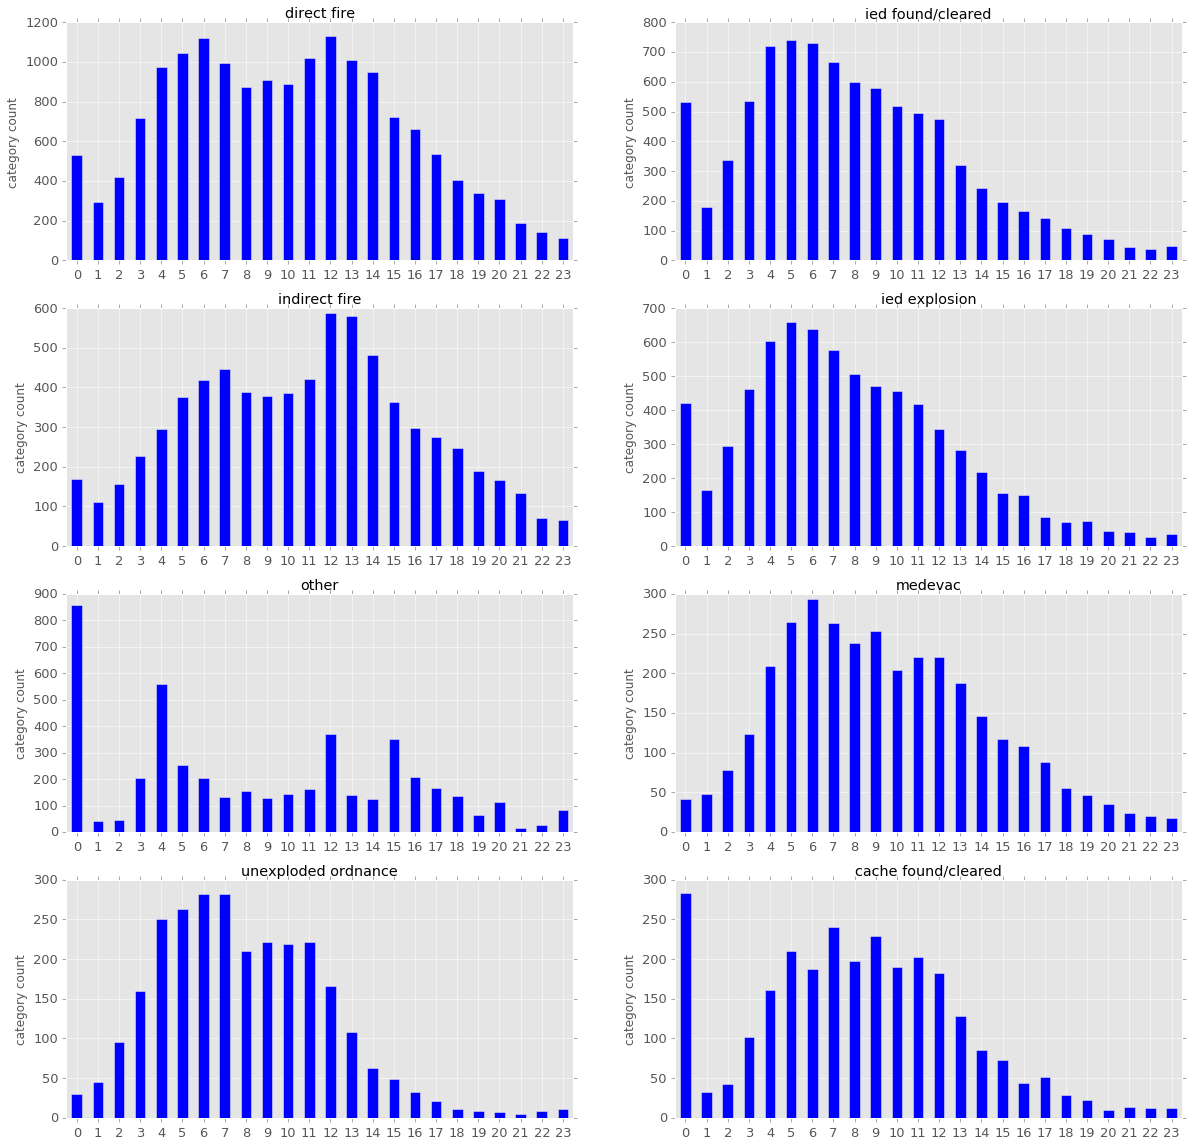

In [7]:
def hourly_category_distribution(data, focus_categories):
    
    index = 1
    for category in focus_categories:
        #filter table by type of category
        db = data[data['Category'] == category]
        #get year counts of that crime
        hour_counts = db['Hour'].value_counts()
        #sort it (from 2004 to 2009)
        hour_counts = hour_counts.sort_index()
        #plot it
        plt.subplot(7,2,index)
        barplot(hour_counts, category, figsize=(20,35), ylabel = 'category count', flag = True, rotation = 0)
        index += 1
        
hourly_category_distribution(data, focus_categories)

## Visualization possibilities

Casualties and wounded recorded per year. A bar plot with one bar for each of the categories:
* Enemy .. Taliban
* HostNation .. Afghan soliders
* Friendly .. NATO forces
* Civilians .. Afghan population

(MACHINE LEARNING: KNN)
> One Map of Afghanistan with incidents (color scheme DisplayColor: enemy activity - RED, friendly activity - BLUE, friend on friend - GREEN).

(MACHINE LEARNING: Cluster K-Means)
> Map with 5 regions and choose one category and cluster all incidents during the war, see how many died at specific incident.

(MACHINE LEARNING: Decision Tree/Random Forest)
> x-axis: morning=6-10, midday=11-14, afternoon=15-17, evening=18-23
> y-axis: prediction score of each category in scatterplot, bubble size according to all incidents in that area 

EXTRA: 
> Word clouds for categories or summary.

An example of all enemy attacks below.

In [9]:
import geoplotlib
from geoplotlib.utils import BoundingBox

def geo_plot(geodata):
    """
    Plot given coordinate input
    """

    # bounding box on the minima and maxima of the data
    geoplotlib.set_bbox(
        BoundingBox(
            max(geodata['lat']), 
            max(geodata['lon']), 
            min(geodata['lat']), 
            min(geodata['lon'])
        ));
    
    # kernel density estimation visualization
    geoplotlib.kde(geodata, bw=5, cut_below=1e-3, cmap='hot', alpha=170)
    # google tiles with lyrs=y ... hybrid
    geoplotlib.tiles_provider({
        'url': lambda zoom, xtile, ytile: 'https://mt1.google.com/vt/lyrs=y&hl=en&x=%d&y=%d&z=%d' % (xtile, ytile, zoom ),
        'tiles_dir': 'DTU-social_data',
        'attribution': 'DTU 02806 Social Data Analysis and Visualization'
    })
    
# only enemy activity
include = (data.Latitude < 38) & (data.Latitude > 30) & (data.Longitude > 55) &(data.Longitude < 75) & (data.DisplayColor == 'RED')

# index geodata
geodata = {
    "lat": data.loc[include].Latitude.tolist(), 
    "lon": data.loc[include].Longitude.tolist()
}

geo_plot(geodata)
geoplotlib.inline();

('smallest non-zero count', 7.1647865443840454e-10)
('max count:', 14.315539361767645)


# Xavier's Part

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import pickle
from collections import Counter
import cPickle as cp
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from __future__ import division

In [4]:
nltk.download()

showing info http://www.nltk.org/nltk_data/


True

Remove useless stuff from the summary and replace the acronyms for the corresponding words.

In [5]:
# We get the rows that contain incidents in the capital
crimes_Kabul = data[data['Region'] == 'RC CAPITAL']
crimes_Kabul.index = range(3191)
summaries = crimes_Kabul['Summary']
categories = crimes_Kabul['Category']

In [6]:
def hasNumbers(word):
    return any(i.isdigit() for i in word)

In [9]:
# To remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

incidence = 0

# Dictionary that will contain all the tokens per summary.
tokens_per_summary_kabul = {}


for s in summaries:
    # First, we get all the tokens of the summary S, which still contains the acronyms
    tokens_with_acronyms = tokenizer.tokenize(str(s))
    
    # It's time now to replace the acronyms
    tokens_no_acronyms = []
    for t in tokens_with_acronyms:
        t = t.lower()
        if t in glossary:
            tokens_no_acronyms.append(glossary[t].lower())
        else:
            tokens_no_acronyms.append(t)
            
    # We remove now the stopwords
    tokens = []
    for w in tokens_no_acronyms:
        if w not in stopwords.words('english') and len(w) > 1 and (hasNumbers(w) == False):
            tokens.append(w)
            
    # Finally, we have the data we wanted and we can store it in the final dictionary
    tokens_per_summary_kabul[incidence] = tokens
    incidence = incidence+1

In [11]:
# we use pickle to store the dictionaries of the films, in order to avoid running the code each time.
pickle.dump(tokens_per_summary_kabul, open("./pickleObjects/tokens_per_summary_kabul.p","wb"))

In [7]:
# Load the data stored using pickle
tokens_per_summary_kabul = pickle.load(open( "./pickleObjects/tokens_per_summary_kabul.p","rb"))

Create a list of unique words

In [8]:
tokens_per_summary_sets = {} # In each key, contains a list with unique words of the summary.
big_list = [] # Contains all the unique lists concatenated. Thus, a word appear as many times as in how many summaries it is.

for key in tokens_per_summary_kabul:
    tokens_per_summary_sets[key] = list(set(tokens_per_summary_kabul[key]))
    big_list += tokens_per_summary_sets[key]

counter = Counter(big_list)

# Finally, we create a set with the unique words that appear in more that 3 files.
unique_words = set()
for c in counter:
    if counter[c] > 3:
        unique_words.add(c)

In [9]:
# We create the dictionary that maps each unique word with an index
unique_words2 = list(unique_words)
d = {unique_words2[i].lower() : i for i in xrange(len(unique_words2))}

Create a matrix with Crime summaries in rows and Unique words in columns, and set each value as the number of occurrences of a specific word in a specific crime summary.

In [78]:
# To remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

feature_vectors_kabul = [[0 for x in range(len(list(unique_words)))] for x in range(3191)] #76911 number of crimes

# Now, we create the feature vectors, using the technique explained in the exercise.

row = 0
for s in summaries:
    # First, we get all the tokens of the summary S, which still contains the acronyms
    tokens_with_acronyms = tokenizer.tokenize(str(s))
    
    # It's time now to replace the acronyms
    tokens_no_acronyms = []
    for t in tokens_with_acronyms:
        t = t.lower()
        if t in glossary:
            tokens_no_acronyms.append(glossary[t].lower())
        else:
            tokens_no_acronyms.append(t)
            
    # We remove now the stopwords
    for w in tokens_no_acronyms:
        if (w in d):
            col = d[w]
            feature_vectors_kabul[row][col] += 1
    row += 1

In [79]:
# we use pickle to store the dictionaries of the films, in order to avoid running the code each time.
cp.dump(feature_vectors_kabul, open("./pickleObjects/feature_vectors_kabul.p","wb"))

In [10]:
# Load the data stored using pickle
feature_vectors_kabul = cp.load(open( "./pickleObjects/feature_vectors_kabul.p","rb"))

Assign an index per each category.

In [11]:
unique_categories = list(set(crimes_Kabul['Category']))

In [12]:
cat2index = {}
index2cat = {}

for i in range (len(unique_categories)):
    cat2index[unique_categories[i]] = i
    
for i in range(len(unique_categories)):
    index2cat[i] = unique_categories[i]

In [13]:
dic_categories = {}

# For each file, we just have to look at what list it is attached and then add the corresponding index.
for i in range(len(categories)):
    dic_categories[i] = cat2index[categories[i]]

In [14]:
top11_categories = ['escalation of force','ied explosion','demonstration','indirect fire','meeting','accident','direct fire',
                    'medevac','ied found/cleared','cache found/cleared','meeting - security']

**RANDOM FOREST**

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(feature_vectors_kabul, dic_categories.values(), test_size=0.2)

In [16]:
forest = RandomForestClassifier(n_estimators = 50)

In [17]:
forest.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
rf_predicted = forest.predict(X_test)

In [19]:
forest.score(X_test,Y_test)

0.77151799687010958

In [55]:
results_rf = {}

for i in top11_categories:
    results_rf[i] = [0,0]
    
for i in range(len(Y_test)):
    key = index2cat[Y_test[i]]
    if key in results_rf.keys():                
        if Y_test[i] == rf_predicted[i]: #if correct prediction
            results_rf[index2cat[Y_test[i]]][0] += 1
        else:
            results_rf[index2cat[Y_test[i]]][1] += 1
            
for i in range(len(top11_categories)):
    c = results_rf[top11_categories[i]][0]
    b = results_rf[top11_categories[i]][1]
    results_rf[top11_categories[i]][0] = (c/(c+b))*100
    results_rf[top11_categories[i]][1] = (b/(c+b))*100

In [56]:
data_rf = pandas.DataFrame()

data_rf['Cat'] = top11_categories
correct = []
bad = []
for i in top11_categories:
    correct.append(results_rf[i][0])
    bad.append(results_rf[i][1])
data_rf['Correct'] = correct
data_rf['Incorrect'] = bad
#save killed data to csv
data_rf.to_csv('rf_top11_p.csv', sep=',', index=False)

**K-NEIGHBORS**

In [28]:
neigh = KNeighborsClassifier(n_neighbors=3)

In [29]:
neigh.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [30]:
nc_predicted = neigh.predict(X_test)

In [31]:
neigh.score(X_test,Y_test)

0.61032863849765262

In [59]:
results_neigh = {}

for i in top11_categories:
    results_neigh[i] = [0,0]
    
for i in range(len(Y_test)):
    key = index2cat[Y_test[i]]
    if key in results_neigh.keys():                
        if Y_test[i] == nc_predicted[i]: #if correct prediction
            results_neigh[index2cat[Y_test[i]]][0] += 1
        else:
            results_neigh[index2cat[Y_test[i]]][1] += 1
            
for i in range(len(top11_categories)):
    c = results_neigh[top11_categories[i]][0]
    b = results_neigh[top11_categories[i]][1]
    results_neigh[top11_categories[i]][0] = (c/(c+b))*100
    results_neigh[top11_categories[i]][1] = (b/(c+b))*100

In [60]:
data_nc = pandas.DataFrame()

data_nc['Cat'] = top11_categories
correct = []
bad = []
for i in top11_categories:
    correct.append(results_neigh[i][0])
    bad.append(results_neigh[i][1])
data_nc['Correct'] = correct
data_nc['Incorrect'] = bad
#save killed data to csv
data_nc.to_csv('nc_top11_p.csv', sep=',', index=False)

**GAUSSIAN**

In [34]:
clf = GaussianNB()

In [35]:
clf.fit(X_train,Y_train)

GaussianNB()

In [36]:
clf_predicted = clf.predict(X_test)

In [37]:
clf.score(X_test,Y_test)

0.39436619718309857

In [63]:
results_clf = {}

for i in list(set(categories)):
    results_clf[i] = [0,0]
    
for i in range(len(Y_test)):
    if Y_test[i] == clf_predicted[i]: #if correct prediction
        results_clf[index2cat[Y_test[i]]][0] += 1
    else:
        results_clf[index2cat[Y_test[i]]][1] += 1
        
for i in range(len(top11_categories)):
    c = results_clf[top11_categories[i]][0]
    b = results_clf[top11_categories[i]][1]
    results_clf[top11_categories[i]][0] = (c/(c+b))*100
    results_clf[top11_categories[i]][1] = (b/(c+b))*100

In [64]:
data_clf = pandas.DataFrame()

data_clf['Cat'] = top11_categories
correct = []
bad = []
for i in top11_categories:
    correct.append(results_clf[i][0])
    bad.append(results_clf[i][1])
data_clf['Correct'] = correct
data_clf['Incorrect'] = bad
#save killed data to csv
data_clf.to_csv('clf_top11_p.csv', sep=',', index=False)

**TREE**

In [46]:
from sklearn import tree

In [47]:
tr = tree.DecisionTreeClassifier()

In [48]:
tr.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [49]:
tree_predicted = tr.predict(X_test)

In [50]:
tr.score(X_test,Y_test)

0.69640062597809071

In [67]:
results_tree = {}

for i in list(set(categories)):
    results_tree[i] = [0,0]
    
for i in range(len(Y_test)):
    if Y_test[i] == tree_predicted[i]: #if correct prediction
        results_tree[index2cat[Y_test[i]]][0] += 1
    else:
        results_tree[index2cat[Y_test[i]]][1] += 1
        
for i in range(len(top11_categories)):
    c = results_tree[top11_categories[i]][0]
    b = results_tree[top11_categories[i]][1]
    results_tree[top11_categories[i]][0] = (c/(c+b))*100
    results_tree[top11_categories[i]][1] = (b/(c+b))*100

In [68]:
data_tr = pandas.DataFrame()

data_tr['Cat'] = top11_categories
correct = []
bad = []
for i in top11_categories:
    correct.append(results_tree[i][0])
    bad.append(results_tree[i][1])
data_tr['Correct'] = correct
data_tr['Incorrect'] = bad
#save killed data to csv
data_tr.to_csv('tr_top11_p.csv', sep=',', index=False)

Map of Kabul with all the incidences

In [9]:
import math
import geoplotlib
from geoplotlib.utils import BoundingBox
import numpy as np

In [10]:
# We get the rows that contain incidents in the capital
crimes_Kabul = data[data['Region'] == 'RC CAPITAL']

In [11]:
def create_geodata(dataset):
    #get latitudes, longitudes and display colors from dataframe
    latitudes = []
    longitudes = []
    colors = []
    for item in dataset['Longitude'].iteritems():
        if ((math.isnan(item[1]) == False) and (item[1] != 70.20531464)): # to remove one outlier
            longitudes.append(float(item[1]))
            latitudes.append(dataset['Latitude'][item[0]])
            colors.append(dataset['DisplayColor'][item[0]])

    #get data in the format geoplotlib requires. We put the geodata in a dictionary structured as follows
    geo_data = {"lat": latitudes,
                "lon": longitudes}
    
    return geo_data, colors

In [12]:
geodata,colors = create_geodata(crimes_Kabul)

In [16]:
def plot_geodata(geodata, cmap_color, enemy, friendly, neutral):

    for i in range(len(colors)):
        if colors[i] == 'RED':
            enemy['lat'].append(geodata['lat'][i])
            enemy['lon'].append(geodata['lon'][i])
        if colors[i] == 'BLUE':
            friendly['lat'].append(geodata['lat'][i])
            friendly['lon'].append(geodata['lon'][i])
        if colors[i] == 'GREEN':
            neutral['lat'].append(geodata['lat'][i])
            neutral['lon'].append(geodata['lon'][i])
    
    geoplotlib.dot(enemy, color='red', point_size = 2.5)
    geoplotlib.dot(friendly, color='blue', point_size = 2.5)
    geoplotlib.dot(neutral, color='green', point_size = 2.5)
    
    # bounding box on the minima and maxima of the data
    geoplotlib.set_bbox(
        BoundingBox(
            max(geodata['lat']), 
            max(geodata['lon']), 
            min(geodata['lat']), 
            min(geodata['lon'])
        ));

    geoplotlib.inline()

In [17]:
    enemy = {}
    enemy['lat'] = []
    enemy['lon'] = []
    friendly = {}
    friendly['lat'] = []
    friendly['lon'] = []
    neutral = {}
    neutral['lat'] = []
    neutral['lon'] = []

plot_geodata(geodata,"hot", enemy, friendly, neutral)

In [26]:
df_geo = pandas.DataFrame()
df_geo['lat'] = enemy['lat'] + friendly['lat'] + neutral['lat']
df_geo['lon'] = enemy['lon'] + friendly['lon'] + neutral['lon']
df_geo['label'] = [1]*len(enemy['lat']) + [2]*len(friendly['lat']) + [3]*len(neutral['lat'])

file_name = 'geodata.csv'
df_geo.to_csv(file_name, sep=',', index = False)